# ML-Challenge - EURO2024

In [2]:
# ----------------------------------GENERAL---------------------------------

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# ----------------------------------VISUALIZATION---------------------------

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# ----------------------------------PRE-PROCESSING---------------------------

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_samples, silhouette_score,classification_report, confusion_matrix

# ----------------------------------PIPELINE AND MODELS----------------------

from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# Load data

In [3]:
# Teams = pd.read_csv('data/Country_players.csv') # teams composition
# E24 = pd.read_csv('data/Euro_24.csv') # programme matchs de poule
# EHist = pd.read_csv('data/Euros_Data.csv') # historical Data of EUROS
# Players = pd.read_csv('data/male_players.csv') # FIFA individual players attribute
HISTORY = pd.read_csv('data/Matches Data.csv') # historical Data of ALL international matches

In [4]:
print(HISTORY.info())
print(HISTORY.head())
print(HISTORY.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3952 entries, 0 to 3951
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  3952 non-null   int64  
 1   Unnamed: 0    3952 non-null   int64  
 2   home_team     3952 non-null   object 
 3   away_team     3952 non-null   object 
 4   home_score    3916 non-null   float64
 5   away_score    3916 non-null   float64
 6   tournament    3952 non-null   object 
 7   city          3952 non-null   object 
 8   country       3952 non-null   object 
 9   neutral       3952 non-null   bool   
 10  winner        3916 non-null   object 
 11  year          3952 non-null   int64  
dtypes: bool(1), float64(2), int64(3), object(6)
memory usage: 343.6+ KB
None
   Unnamed: 0.1  Unnamed: 0 home_team away_team  home_score  away_score  \
0             0           0  Scotland   England         0.0         0.0   
1             1           1   England  Scotland         4.0    

# drop unwanted data

In [5]:
# drop the unwanted columns.
HISTORY.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)
# and all data before 2016
HISTORY= HISTORY[HISTORY['year']>=2016]
print(HISTORY.info())

<class 'pandas.core.frame.DataFrame'>
Index: 543 entries, 3409 to 3951
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   home_team   543 non-null    object 
 1   away_team   543 non-null    object 
 2   home_score  507 non-null    float64
 3   away_score  507 non-null    float64
 4   tournament  543 non-null    object 
 5   city        543 non-null    object 
 6   country     543 non-null    object 
 7   neutral     543 non-null    bool   
 8   winner      507 non-null    object 
 9   year        543 non-null    int64  
dtypes: bool(1), float64(2), int64(1), object(6)
memory usage: 43.0+ KB
None


home_team      0
away_team      0
home_score    36
away_score    36
tournament     0
city           0
country        0
neutral        0
winner        36
year           0
dtype: int64


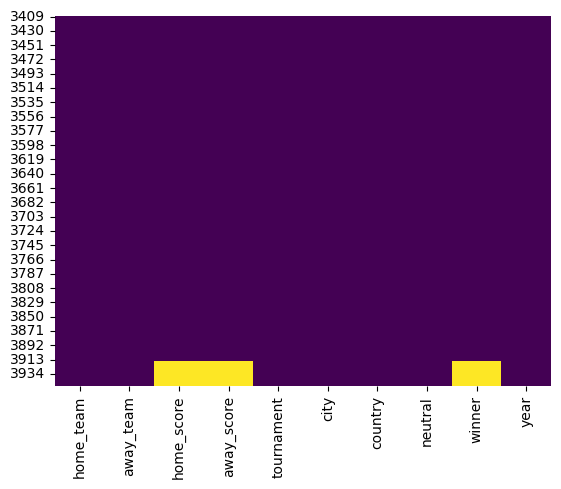

In [6]:
print(HISTORY.isna().sum()) # nb of NAs (or isnull())
# print(HISTORY[HISTORY.isnull().any(axis=1)]) # shows rows with at least one missing value
sns.heatmap(HISTORY.isna(), cbar=False, cmap='viridis'); # Visualize missing values... 

# all the NAs values are the programed Euro 2024 macthes => drop

In [7]:
HISTORY.tail(37)
HISTORY.dropna(inplace=True)
print(HISTORY.isna().sum())

home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
winner        0
year          0
dtype: int64


# our target is not "winner" but an "encoded winner", where its Home or Away (or Draw).

In [8]:
HISTORY["Winner_HoAw"] = HISTORY.apply(lambda row: 'Home' if row['winner'] == row['home_team']  else ('Away' if row['winner'] == row['away_team'] else 'Draw'), axis=1)
HISTORY.insert(HISTORY.columns.get_loc('winner') + 1, 'Winner_HoAw', HISTORY.pop('Winner_HoAw'))
HISTORY

,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winner,Winner_HoAw,year
3409,Poland,Serbia,1.0,0.0,Friendly,Poznań,Poland,False,Poland,Home,2016
3410,Czech Republic,Scotland,0.0,1.0,Friendly,Prague,Czech Republic,False,Scotland,Away,2016
3411,Italy,Spain,1.0,1.0,Friendly,Udine,Italy,False,Draw,Draw,2016
3412,Netherlands,France,2.0,3.0,Friendly,Amsterdam,Netherlands,False,France,Away,2016
3413,Austria,Albania,2.0,1.0,Friendly,Vienna,Austria,False,Austria,Home,2016
...,...,...,...,...,...,...,...,...,...,...,...
3911,Italy,Turkey,0.0,0.0,Friendly,Bologna,Italy,False,Draw,Draw,2024
3912,Poland,Ukraine,3.0,1.0,Friendly,Warsaw,Poland,False,Poland,Home,2024
3913,Portugal,Croatia,1.0,2.0,Friendly,Oeiras,Portugal,False,Croatia,Away,2024
3914,Switzerland,Austria,1.0,1.0,Friendly,Sankt Gallen,Switzerland,False,Draw,Draw,2024


# add power rankings


In [9]:
POWER = pd.read_csv('data/final_power_rankings.csv') 
print(POWER.info())
POWER.sort_values(by='Country')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Country                     24 non-null     object 
 1   Rank                        24 non-null     int64  
 2   EM 2024 Org Power Rankings  24 non-null     int64  
 3   power_ranking_3             24 non-null     int64  
 4   average_ranking             24 non-null     float64
 5   adjusted_rank               24 non-null     int64  
 6   scaled_adjusted_rank        24 non-null     float64
dtypes: float64(2), int64(4), object(1)
memory usage: 1.4+ KB
None


,Country,Rank,EM 2024 Org Power Rankings,power_ranking_3,average_ranking,adjusted_rank,scaled_adjusted_rank
22,Albania,23,23,23,23.000000,2,-1.476115
10,Austria,8,14,13,11.666667,14,0.231199
3,Belgium,3,7,2,4.000000,21,1.227131
8,Croatia,9,9,8,8.666667,16,0.515751
15,Czech Republic,16,19,17,17.333333,8,-0.622458
9,Denmark,11,10,11,10.666667,15,0.373475
1,England,4,2,3,3.000000,23,1.511684
0,France,1,1,1,1.000000,24,1.653960
23,Georgia,24,24,24,24.000000,1,-1.618391
5,Germany,5,3,9,5.666667,19,0.942579


In [10]:
# Merge POWER DataFrame with HISTORY DataFrame on home_team
HISTORY = HISTORY.merge(POWER[['Country', 'scaled_adjusted_rank']],
                              left_on='home_team', right_on='Country', how='left')
HISTORY = HISTORY.rename(columns={'scaled_adjusted_rank': 'Strength_Home_2024'})

# Merge POWER DataFrame with HISTORY DataFrame on away_team
HISTORY = HISTORY.merge(POWER[['Country', 'scaled_adjusted_rank']],
                              left_on='away_team', right_on='Country', how='left')
HISTORY = HISTORY.rename(columns={'scaled_adjusted_rank': 'Strength_Away_2024'})

# Drop the extra 'Country' columns from the merges
HISTORY.drop(columns=['Country_x', 'Country_y'], inplace=True)

HISTORY

,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winner,Winner_HoAw,year,Strength_Home_2024,Strength_Away_2024
0,Poland,Serbia,1.0,0.0,Friendly,Poznań,Poland,False,Poland,Home,2016,-0.907010,-0.622458
1,Czech Republic,Scotland,0.0,1.0,Friendly,Prague,Czech Republic,False,Scotland,Away,2016,-0.622458,-0.907010
2,Italy,Spain,1.0,1.0,Friendly,Udine,Italy,False,Draw,Draw,2016,0.658027,1.084855
3,Netherlands,France,2.0,3.0,Friendly,Amsterdam,Netherlands,False,France,Away,2016,0.800303,1.653960
4,Austria,Albania,2.0,1.0,Friendly,Vienna,Austria,False,Austria,Home,2016,0.231199,-1.476115
...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,Italy,Turkey,0.0,0.0,Friendly,Bologna,Italy,False,Draw,Draw,2024,0.658027,-0.337906
503,Poland,Ukraine,3.0,1.0,Friendly,Warsaw,Poland,False,Poland,Home,2024,-0.907010,-0.195630
504,Portugal,Croatia,1.0,2.0,Friendly,Oeiras,Portugal,False,Croatia,Away,2024,1.369407,0.515751
505,Switzerland,Austria,1.0,1.0,Friendly,Sankt Gallen,Switzerland,False,Draw,Draw,2024,0.088923,0.231199


In [11]:
HISTORY['tournament'].unique()

array(['Friendly', 'UEFA Euro', 'FIFA World Cup qualification',
       'FIFA World Cup', 'UEFA Nations League', 'UEFA Euro qualification'],
      dtype=object)

In [ ]:
HISTORY.

# Train test split

In [12]:
# Split data into features and target variable

X = HISTORY.drop(columns=['Winner_HoAw', 'home_score', 'away_score', 'winner'], axis=1) # otherwise data leakage !
Y = HISTORY['Winner_HoAw']

# Split data into training and testing sets, classically 80/20 for classification
from sklearn.model_selection import train_test_split
# stratify = both train and test have the same distributions of the dependent variable, here y
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y) 
print("Size of training set:", X_train.shape)
print("Size of test set:", X_test.shape)

Size of training set: (405, 9)
Size of test set: (102, 9)


In [13]:
# Check if train-test split has returned balanced data sets
print('TRAIN DATA:\n',Y_train.value_counts(normalize=True))
print('\nTEST DATA:\n', Y_test.value_counts(normalize=True))


TRAIN DATA:
 Winner_HoAw
Home    0.424691
Away    0.298765
Draw    0.276543
Name: proportion, dtype: float64

TEST DATA:
 Winner_HoAw
Home    0.431373
Away    0.294118
Draw    0.274510
Name: proportion, dtype: float64


In [14]:
X_train.head()

,home_team,away_team,tournament,city,country,neutral,year,Strength_Home_2024,Strength_Away_2024
481,England,Italy,UEFA Euro qualification,London,England,False,2023,1.511684,0.658027
460,Slovenia,Denmark,UEFA Euro qualification,Ljubljana,Slovenia,False,2023,-1.333838,0.373475
284,Hungary,Turkey,UEFA Nations League,Budapest,Hungary,False,2020,-0.053354,-0.337906
210,Slovenia,Poland,UEFA Euro qualification,Ljubljana,Slovenia,False,2019,-1.333838,-0.907010
492,Netherlands,Scotland,Friendly,Amsterdam,Netherlands,False,2024,0.800303,-0.907010


In [15]:
X_train[X_train.isnull().any(axis=1)]

,home_team,away_team,tournament,city,country,neutral,year,Strength_Home_2024,Strength_Away_2024


In [16]:
Y_train.head()

481    Home
460    Draw
284    Home
210    Home
492    Home
Name: Winner_HoAw, dtype: object

# Firsts models Auto-ML with FLAML : onyl with rankings from 2024
Here we will use the flaml library to build classification models. Do check out the package documentation when needed.

FLAML is powered by a new, cost-effective hyperparameter optimization and learner selection method invented by Microsoft Research.

FLAML leverages the structure of the search space to choose a search order optimized for both cost and error. For example, the system tends to propose cheap configurations at the beginning stage of the search, but quickly moves to configurations with high model complexity and large sample size when needed in the later stage of the search.

For another example, it favors cheap learners in the beginning but penalizes them later if the error improvement is slow.

The cost-bounded search and cost-based prioritization make a big difference in the search efficiency under budget constraints.

In [31]:
from flaml import AutoML

automl = AutoML()

automl_settings = {
    "time_budget": 500, # 5 mins to try and select the best model
    "metric": 'accuracy',
    "task": 'multiclass', # since we have 3 classes
    "log_file_name": 'mylog.log'
}

In [32]:
automl.fit(X_train=X_train, y_train=Y_train.values,
           **automl_settings)

# nearly only uses complex models: List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']

[flaml.automl.logger: 06-13 14:38:00] {1680} INFO - task = multiclass
[flaml.automl.logger: 06-13 14:38:00] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 06-13 14:38:00] {1789} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 06-13 14:38:00] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 06-13 14:38:00] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-13 14:38:01] {2345} INFO - Estimated sufficient time budget=2368s. Estimated necessary time budget=58s.
[flaml.automl.logger: 06-13 14:38:01] {2392} INFO -  at 0.3s,	estimator lgbm's best error=0.5654,	best estimator lgbm's best error=0.5654
[flaml.automl.logger: 06-13 14:38:01] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-13 14:38:01] {2392} INFO -  at 0.5s,	estimator lgbm's best error=0.5654,	best estimator lgbm's best error=0.5654
[flaml.automl.logger: 06-1

In [33]:
print('automl.best_estimator: \n-----------\n',automl.best_estimator)
print('\nautoml.best_config: \n-----------\n',automl.best_config)
print('\nautoml.model.get_params: \n-----------\n',automl.model.get_params())


automl.best_estimator: 
-----------
 xgboost

automl.best_config: 
-----------
 {'n_estimators': 5, 'max_leaves': 4, 'min_child_weight': 2.136305191404285, 'learning_rate': 0.05397608841583764, 'subsample': 0.881922930103989, 'colsample_bylevel': 0.8369139586584522, 'colsample_bytree': 0.9259856665376008, 'reg_alpha': 0.0009765625, 'reg_lambda': 970.1472404664844}

automl.model.get_params: 
-----------
 {'n_estimators': 5, 'max_leaves': 4, 'min_child_weight': 2.136305191404285, 'learning_rate': 0.05397608841583764, 'subsample': 0.881922930103989, 'colsample_bylevel': 0.8369139586584522, 'colsample_bytree': 0.9259856665376008, 'reg_alpha': 0.0009765625, 'reg_lambda': 970.1472404664844, 'n_jobs': -1, 'max_depth': 0, 'grow_policy': 'lossguide', 'tree_method': 'hist', 'verbosity': 0, 'task': <flaml.automl.task.generic_task.GenericTask object at 0x000001C548F0A0B0>, '_estimator_type': 'classifier'}


### export the model

In [39]:
import pickle
# Serialize the model to a file
with open('MODEL_2024rankings_accuracy.pkl', 'wb') as f:
    pickle.dump(automl.best_estimator, f)

### Reusing the Model

In [40]:
# Load the saved model
with open('MODEL_2024rankings_accuracy.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

              precision    recall  f1-score   support

        Away       0.67      0.27      0.38        30
        Draw       0.31      0.14      0.20        28
        Home       0.51      0.89      0.64        44

    accuracy                           0.50       102
   macro avg       0.49      0.43      0.41       102
weighted avg       0.50      0.50      0.44       102



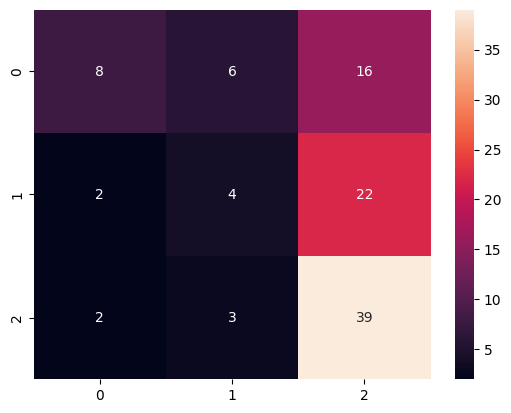

In [26]:
predictions = loaded_model.predict(X_test)
cf = confusion_matrix(Y_test, predictions)
print(classification_report(Y_test, predictions))
sns.heatmap(cf, annot=True);